In [30]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import nibabel as nib
from scipy.spatial.distance import euclidean

In [31]:
plt.rcParams.update({
    'font.size': 16,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

In [32]:
def add_subplot_label(ax, label, x=-.21, y=1.225, fontsize=26):
    ax.text(x, y, label,  # Adjust left of y-axis
            transform=ax.transAxes,
            fontsize=fontsize, va='top', ha='right')


In [33]:
out_dir='../output/ori_simulations'
n_layers=11

In [34]:
vx_loc, vx_adj, surf_norm = nib.load("/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/surf/multilayer.11.ds.link_vector.fixed.gii").agg_data()
layers_loc = np.array(np.split(vx_loc, n_layers, axis=0))
cortical_thickness = np.array([euclidean(layers_loc[0, i, :], layers_loc[-1, i, :]) for i in range(layers_loc.shape[1])])


In [47]:
# Define the simulation and reconstruction methods
methods = [
    "link_vector.fixed", 
    "orig_surf_norm.fixed", "orig_surf_norm.not_fixed",
    "cps.fixed", "cps.not_fixed", 
    "ds_surf_norm.fixed", "ds_surf_norm.not_fixed"
]

# Format method names for plotting (remove underscores)
formatted_methods = ['LV','OSNf','OSN','CPSf','CPS','DSNf','DSN']

# Initialize a matrix to store the average errors
error_matrix = np.zeros((7, 7))
relative_f_pial_sim = np.zeros((7,7,n_layers))
        
# Iterate through all combinations of methods
for i, sim_method in enumerate(methods):
    for j, reco_method in enumerate(methods):
        # Construct the file name
        file_name = f"vx_11284_sim_{sim_method}_reco_{reco_method}.pickle"
        file_path = os.path.join(out_dir, file_name)
        
        # Load the .pickle file
        try:
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
            
            # Extract the layerF matrix
            layerF = data['layerF']
            
            # Subtract the minimum F-value for each combination
            relative_f_pial_sim[i, j, :] = layerF[:,0]-np.min(layerF[:,0])

            # Calculate the observed peaks (row index of max value for each column)
            observed_peaks = np.argmax(layerF, axis=0)
            
            # Calculate the ideal peaks (diagonal)
            ideal_peaks = np.arange(layerF.shape[1])
            
            # Compute the errors (distance between observed and ideal peaks)
            errors = np.abs(observed_peaks - ideal_peaks)
            
            # Calculate the average error for this file
            avg_error = np.mean(errors)
            
            # Store the average error in the error matrix
            error_matrix[i, j] = avg_error
        
        except FileNotFoundError:
            # If the file is missing, mark it with NaN
            error_matrix[i, j] = np.nan


In [62]:
# Initialize a matrix to accumulate errors for all vertices

# List to store the unique vertex numbers
vertex_numbers = set()

# Iterate through all files in the directory to find the vertex numbers
for file_name in os.listdir(out_dir):
    # Match the pattern vx_<vertex_number>_sim_ with regular expression
    match = re.match(r"vx_(\d+)_sim_", file_name)
    if match:
        vertex_number = int(match.group(1))
        vertex_numbers.add(vertex_number)


error_matrix_all = np.zeros((len(vertex_numbers),7, 7))
error_matrix_mm_all = np.zeros((len(vertex_numbers),7, 7))

# Iterate through all detected vertices
for v_idx, vertex_num in enumerate(vertex_numbers):
    layer_multiplier = cortical_thickness[vertex_num] / n_layers
    for i, sim_method in enumerate(methods):
        for j, reco_method in enumerate(methods):
            # Construct the file name for the current vertex
            file_name = f"vx_{vertex_num}_sim_{sim_method}_reco_{reco_method}.pickle"
            file_path = os.path.join(out_dir, file_name)
            
            # Load the .pickle file
            with open(file_path, 'rb') as file:
                data = pickle.load(file)

            # Extract the layerF matrix
            layerF = data['layerF']

            # Calculate the observed peaks (row index of max value for each column)
            observed_peaks = np.argmax(layerF, axis=1)

            # Calculate the ideal peaks (diagonal)
            ideal_peaks = np.arange(layerF.shape[1])

            # Compute the errors (distance between observed and ideal peaks)
            errors = np.abs(observed_peaks - ideal_peaks)

            # Accumulate the errors
            error_matrix_all[v_idx, i, j] = np.mean(errors)
            error_matrix_mm_all[v_idx, i, j] = np.mean(errors*layer_multiplier)           


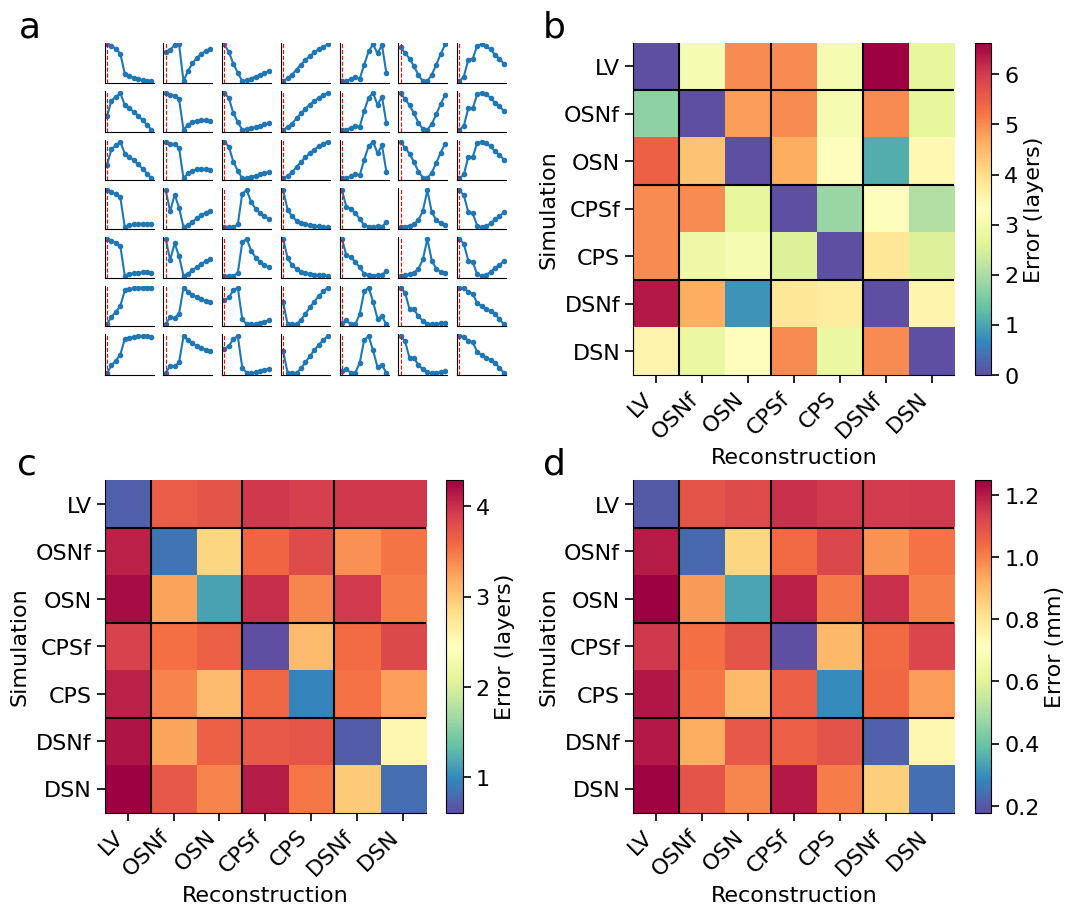

In [87]:
# Plot the results
fig=plt.figure(figsize=(12, 10), facecolor="white")
gs = GridSpec(16, 16)

for sim_orient in range(7):
    for recon_orient in range(7):
        ax = fig.add_subplot(gs[sim_orient, recon_orient])
        ax.plot(range(11), relative_f_pial_sim[sim_orient, recon_orient, :], marker='.')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axvline(0, color='red', linestyle='--', linewidth=0.8)  # Highlight surface 0
        if sim_orient==0 and recon_orient==0:
            add_subplot_label(ax,'a',x=-1.3,y=1.8)
        
# Plot the heatmap of average errors
ax = fig.add_subplot(gs[:7, 9:])
cax = ax.imshow(error_matrix, cmap='Spectral_r', aspect='auto', interpolation='none')
ax.axhline(0.5,color='k')
ax.axhline(2.5,color='k')
ax.axhline(4.5,color='k')
ax.axvline(0.5,color='k')
ax.axvline(2.5,color='k')
ax.axvline(4.5,color='k')
# Add labels and titles
ax.set_xticks(np.arange(len(methods)))
ax.set_yticks(np.arange(len(methods)))
ax.set_xticklabels(formatted_methods, rotation=45, ha="right")
ax.set_yticklabels(formatted_methods)
ax.set_xlabel("Reconstruction")
ax.set_ylabel("Simulation")
fig.colorbar(cax, label="Error (layers)", ax=ax)
add_subplot_label(ax,'b',y=1.1)



ax = fig.add_subplot(gs[9:, :7])
cax = ax.imshow(np.mean(error_matrix_all,axis=0), cmap='Spectral_r', aspect='auto', interpolation='none')
ax.axhline(0.5,color='k')
ax.axhline(2.5,color='k')
ax.axhline(4.5,color='k')
ax.axvline(0.5,color='k')
ax.axvline(2.5,color='k')
ax.axvline(4.5,color='k')
# Add labels and titles
ax.set_xticks(np.arange(len(methods)))
ax.set_yticks(np.arange(len(methods)))
ax.set_xticklabels(formatted_methods, rotation=45, ha="right")
ax.set_yticklabels(formatted_methods)
ax.set_xlabel("Reconstruction")
ax.set_ylabel("Simulation")
fig.colorbar(cax, label="Error (layers)", ax=ax)
add_subplot_label(ax,'c',y=1.1)


ax = fig.add_subplot(gs[9:, 9:])
cax = ax.imshow(np.mean(error_matrix_mm_all,axis=0), cmap='Spectral_r', aspect='auto', interpolation='none')
ax.axhline(0.5,color='k')
ax.axhline(2.5,color='k')
ax.axhline(4.5,color='k')
ax.axvline(0.5,color='k')
ax.axvline(2.5,color='k')
ax.axvline(4.5,color='k')
# Add labels and titles
ax.set_xticks(np.arange(len(methods)))
ax.set_yticks(np.arange(len(methods)))
ax.set_xticklabels(formatted_methods, rotation=45, ha="right")
ax.set_yticklabels(formatted_methods)
ax.set_xlabel("Reconstruction")
ax.set_ylabel("Simulation")
fig.colorbar(cax, label="Error (mm)", ax=ax)
add_subplot_label(ax,'d',y=1.1)

# Adjust layout and show the plot
#plt.tight_layout()
plt.savefig(f"figure_05_orientation.pdf")